In [26]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

# Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem Definition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?
> 
## 2. Data

The data is doqnoaded from Kaggle Bluebook for Bulldozers competition:

There are 3 main datasets:

    Train.csv is the training set, which contains data through the end of 2011.
    Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
    Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.


## 3. Evaluation

The evaluation metric for this competition is the RSMLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: 

https://www.kaggle.com/c/bluebook-for-bulldozers/data

Note: The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary if you download zipped Kaggle file for the project.


In [27]:
# import training and validation sets
df = pd.read_csv('data/TrainAndValid.csv', low_memory=False)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [29]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

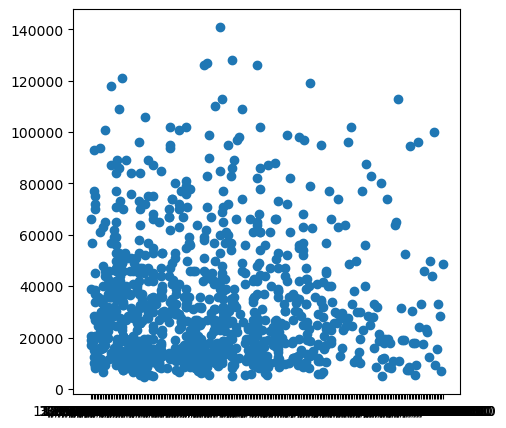

In [30]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000]);

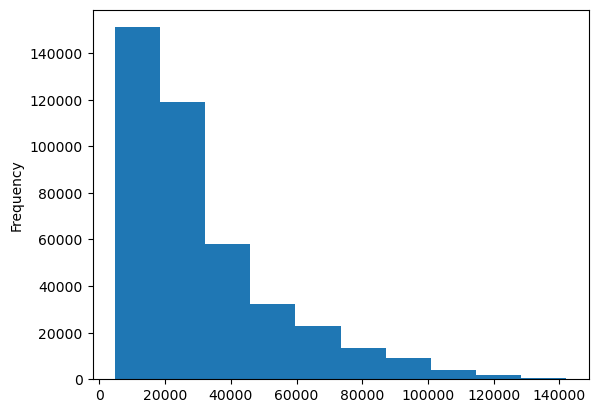

In [31]:
df.SalePrice.plot.hist();

In [32]:
df['saledate'].head()

0    11/16/2006 0:00
1     3/26/2004 0:00
2     2/26/2004 0:00
3     5/19/2011 0:00
4     7/23/2009 0:00
Name: saledate, dtype: object

 ### Parsing dates

When we work with time series data, we want to enrich the time & date component as much as possible 

We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter.

In [33]:
 df = pd.read_csv('data/TrainAndValid.csv',
                 low_memory=False,
                 parse_dates=['saledate'])

In [34]:
df.saledate.dtype

dtype('<M8[ns]')

In [35]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

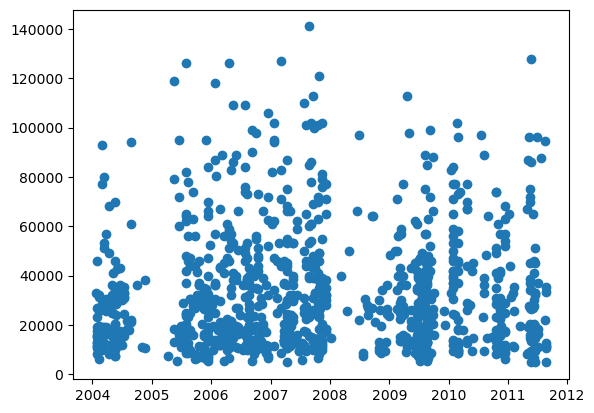

In [36]:
fig, ax = plt.subplots()
ax.scatter (df['saledate'][:1000], df['SalePrice'][:1000]);

In [37]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


### Sort DataFrame by saledate

When working with time series data, it's a good idea to sort it by date.

In [39]:
# Sort DataFrame in date order

df.sort_values(by=['saledate'], inplace=True, ascending=True)
df.saledate.head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame

We make a copy of the original dataframe so when we manipulate the copy, we've still got our original data.

In [40]:
# Make a copy
df_temp = df.copy()
df_temp.saledate.head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [41]:
 df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

### Add datetime parameters for saledate column

In [42]:
df_temp['saleYear'] = df_temp.saledate.dt.year
df_temp['saleMonth'] = df_temp.saledate.dt.year
df_temp['saleDay'] = df_temp.saledate.dt.year
df_temp['saleDayOfWeek'] = df_temp.saledate.dt.year
df_temp['saleDayOfYear'] = df_temp.saledate.dt.year


In [43]:
# Now we've enriched our DataFrame with date time features, we can remove saledate column
df_temp.drop('saledate', axis=1, inplace=True)

In [44]:
# Check the values of different columns
df_temp.state.value_counts()


state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

## 5. Modelling

we've done enough EDA (we could always do more) but let's start to do some model-driven EDA.

In [45]:
# Let's build a machie learning model
from sklearn.metrics import RandomForestRegressor

model = RandomForestRegressor(
    njobs=-1,
    random_state=42
)

model.fit(df_temp.drop('SalePrice', axis=1), df_temp['SalePrice'])

ImportError: cannot import name 'RandomForestRegressor' from 'sklearn.metrics' (C:\Users\ysfkl\December\bulldozer-price-prediction-project\env\lib\site-packages\sklearn\metrics\__init__.py)

In [ ]:
df_temp.isna().sum()

### Convert string to categories

One way we can turn all of our data into numbers is by converting them into pandas categories.

We can check the different datatypes compatible with pandas here:
https://pandas.pydata.org/docs/reference/api/pandas.api.types.is_string_dtype.html

In [46]:
pd.api.types.is_string_dtype(df_temp['UsageBand'])

False

In [47]:
# Find the columns containing strings
i=0
for label, content in df_temp.items():
    if pd.api.types.is_object_dtype(content):
        df_temp[label] = content.astype('category').cat.as_ordered()

In [48]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [49]:
df_temp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [50]:
df_temp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

In [51]:
df_temp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

Thanks to pandas Categories we now have a way to access all of our data in the form of numbers.

Still bunch of missing data

### Save preprocessed data

In [52]:
df_temp.to_csv('data/train_temp.csv', index=False)

In [53]:
df_temp = pd.read_csv('data/train_temp.csv', low_memory=False)

In [54]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

### Fill missing values

#### Fill numerical missing values first

In [55]:
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(content)

0         1646770
1         1821514
2         1505138
3         1671174
4         1329056
           ...   
412693    6302984
412694    6324811
412695    6313029
412696    6266251
412697    6283635
Name: SalesID, Length: 412698, dtype: int64
0          9500.0
1         14000.0
2         50000.0
3         16000.0
4         22000.0
           ...   
412693    16000.0
412694     6000.0
412695    16000.0
412696    55000.0
412697    34000.0
Name: SalePrice, Length: 412698, dtype: float64
0         1126363
1         1194089
2         1473654
3         1327630
4         1336053
           ...   
412693    1915521
412694    1919104
412695    1918416
412696     509560
412697    1869284
Name: MachineID, Length: 412698, dtype: int64
0          8434
1         10150
2          4139
3          8591
4          4089
          ...  
412693     5266
412694    19330
412695    17244
412696     3357
412697     4701
Name: ModelID, Length: 412698, dtype: int64
0         132
1         132
2         132
3     

In [56]:
# Check for which numeric columns have null values
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [57]:
# Fill numeric rows with the median
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing
            df_temp[label+'_is_missing'] = pd.isnull(content)
            # Fill missing numeric values with median
            print(content)
            df_temp[label] = content.fillna(content.median())

0         18.0
1         99.0
2         99.0
3         99.0
4         99.0
          ... 
412693    99.0
412694    99.0
412695    99.0
412696    99.0
412697    99.0
Name: auctioneerID, Length: 412698, dtype: float64
0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
412693   NaN
412694   NaN
412695   NaN
412696   NaN
412697   NaN
Name: MachineHoursCurrentMeter, Length: 412698, dtype: float64


In [58]:
len(df_temp)

412698

In [59]:
# Check if there's any null numeric values
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [60]:
# Check to see how many examples were missing
df_temp.auctioneerID_is_missing.value_counts()

auctioneerID_is_missing
False    392562
True      20136
Name: count, dtype: int64

### Filling and turning categorical variables into numbers

In [61]:
# Check for columns which aren't numeric
for label, content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [62]:
# Turn categorical variables into numbers and fill missing
for label, content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing values
        df_temp[label + '_is_missing_'] = pd.isnull(content)
        # Turn categories into numbers and add +1
        df_temp[label] = pd.Categorical(content).codes + 1

In [63]:
pd.Categorical(df_temp['state']).codes + 1

array([44,  9,  9, ...,  5,  5,  5], dtype=int8)

In [64]:
pd.Categorical(df_temp['UsageBand']).codes+1

array([1, 1, 1, ..., 1, 1, 1], dtype=int8)

In [65]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing_
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [66]:
df_temp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing_,False,True,False,True,False
Blade_Type_is_missing_,False,True,False,True,False
Travel_Controls_is_missing_,False,True,False,True,False
Differential_Type_is_missing_,True,False,True,False,True


In [67]:
df_temp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
                                ..
Backhoe_Mounting_is_missing_     0
Blade_Type_is_missing_           0
Travel_Controls_is_missing_      0
Differential_Type_is_missing_    0
Steering_Controls_is_missing_    0
Length: 103, dtype: int64

Now that all of our data is numeric as well as our dataframe has no missing values, we should be able to build a machine learning model.

In [68]:
%%time
# Instantiate model
model = RandomForestRegressor(n_jobs=-1, random_state=42)

X= df_temp.drop('SalePrice', axis=1)
y= df_temp['SalePrice']

# Fit the model
model.fit(X, y)


CPU times: total: 42min 26s
Wall time: 5min 58s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [69]:
# Score the model
model.score(X, y)

0.9868344813536277

**Question:** Why doesn't the above metric hold water?

### Splitting data into train/validation sets

In [70]:
df_temp.saleYear.value_counts()

saleYear
2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: count, dtype: int64

In [71]:
# Split data into training and validation
df_val = df_temp[df_temp['saleYear'] == 2012]
df_train = df_temp[df_temp['saleYear'] != 2012]
len(df_val), len(df_train)

(11573, 401125)

In [72]:
# Split data into X&y
X_train, y_train =df_train.drop('SalePrice', axis=1), df_train['SalePrice'] 
X_val, y_val =df_val.drop('SalePrice', axis=1), df_val['SalePrice'] 

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((401125, 102), (401125,), (11573, 102), (11573,))

### Building an evaluation function

In [73]:
# Create evaluation function (the competition uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    scores = {
        "Training MAE":mean_absolute_error(y_train, train_preds),
        "Valid MAE":mean_absolute_error(y_val, val_preds),
        "Training RMSLE":rmsle(y_train, train_preds),
        "Valid RMSLE":rmsle(y_val, val_preds),
        "Training R^2": r2_score(y_train, train_preds),
        "Valid R^2":r2_score(y_val, val_preds)
    }
    return scores

## Testing on our model on a subset (to tune hyperparameters)

In [74]:
# This takes far too long
# %%time

In [75]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000)


In [76]:
%%time
# Cutting down on the max number of samples each estimator can see improve the speed
model.fit(X_train, y_train)

CPU times: total: 1min 38s
Wall time: 14.6 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [77]:
show_scores(model)

{'Training MAE': 5478.5995138423195,
 'Valid MAE': 6996.347731789509,
 'Training RMSLE': 0.25400109294953427,
 'Valid RMSLE': 0.2841384933585487,
 'Training R^2': 0.8645073904336693,
 'Valid R^2': 0.8367823007540407}

### Hyperparameter tuning with RandomizedSearchCV

In [78]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hperparameters
rf_grid= {'n_estimators': np.arange(10,100,10),
         'max_depth': [None, 3, 5, 10],
         'min_samples_split': np.arange(2, 20, 2),
         'min_samples_leaf': np.arange(2, 20, 2),
         'max_features': [0.5, 1, 'sqrt', 'auto'],
         'max_samples':[10000] 
         }
# Instantiate RandomizedSearchCV model
rs_model= RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42), 
                            param_distributions=rf_grid,
                            n_iter=2,
                            cv=5,
                            verbose=True 
                            )
# Fit the RandomizedSearchCV model

rs_model.fit(X_train, y_train, error_score='raise')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ysfkl\December\bulldozer-price-prediction-project\env\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ysfkl\December\bulldozer-price-prediction-project\env\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\ysfkl\December\bulldozer-price-prediction-project\env\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\ysfkl\December\bulldozer-price-prediction-project\env\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestRegressor must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.

--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ysfkl\December\bulldozer-price-prediction-project\env\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ysfkl\December\bulldozer-price-prediction-project\env\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
TypeError: BaseForest.fit() got an unexpected keyword argument 'error_score'


In [79]:
# Find the best model hyperparameters
rs_model.best_params_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [ ]:
# Evaluate the randomizedSearch Model
show_scores(rs_model)

### Train a model with the best hyperparameters

**Note:** These were found after 100 iterations of `RandomizedSearchCV`

In [86]:
%%time

# Most ideal hyperparameters

ideal_model = RandomForestRegressor(
    n_estimators=40,
    min_samples_leaf=1,
    min_samples_split=14,
    max_features=0.5,
    n_jobs=-1,
    max_samples=None
)

# Fit the ideal model
ideal_model.fit(X_train, y_train)

CPU times: total: 5min 52s
Wall time: 46.3 s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1)

In [ ]:
#Scores for ideal model (trained on all the data)
show_scores(ideal_model)

In [ ]:
show_scores(rs_model)

## Make predictions on test data


In [147]:
# import the test data
df_test = pd.read_csv('data/Test.csv', low_memory=False, parse_dates=['saledate'])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [148]:
# Make predictions on the test dataset
test_preds = ideal_model.predict(df_test)


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- saledate
Feature names seen at fit time, yet now missing:
- Backhoe_Mounting_is_missing_
- Blade_Extension_is_missing_
- Blade_Type_is_missing_
- Blade_Width_is_missing_
- Coupler_System_is_missing_
- ...


### Preprocessing the data (getting the test dataset in the same format as our training data set)

In [149]:
df_test.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

In [150]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

In [151]:
len(df_test.columns)

52

In [152]:
len(X_train.columns)

102

In [153]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing_,Stick_Length_is_missing_,Thumb_is_missing_,Pattern_Changer_is_missing_,Grouser_Type_is_missing_,Backhoe_Mounting_is_missing_,Blade_Type_is_missing_,Travel_Controls_is_missing_,Differential_Type_is_missing_,Steering_Controls_is_missing_
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


In [154]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    df['saleYear'] = df.saledate.dt.year
    df['saleMonth'] = df.saledate.dt.year
    df['saleDay'] = df.saledate.dt.year
    df['saleDayOfWeek'] = df.saledate.dt.year
    df['saleDayOfYear'] = df.saledate.dt.year

    df.drop('saledate', axis=1, inplace=True)
    
    # Fill the numeric rows with median
    # Fill numeric rows with the median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing
                df[label+'_is_missing'] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
                
        #Filled categorical missing data and turn categories into numeric values
        if not pd.api.types.is_numeric_dtype(content):
            df[label + "_is_missing"] = pd.isnull(content)
            # We add +1 to the category code because pandas encode
            df[label] = pd.Categorical(content).codes+1

    return df

In [155]:
# Process the test data

df_test = preprocess_data(df_test)


In [156]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing_,Stick_Length_is_missing_,Thumb_is_missing_,Pattern_Changer_is_missing_,Grouser_Type_is_missing_,Backhoe_Mounting_is_missing_,Blade_Type_is_missing_,Travel_Controls_is_missing_,Differential_Type_is_missing_,Steering_Controls_is_missing_
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


In [157]:
# Find Missing column
missing =  set(df_test.columns) - set(X_train.columns)
missing

{'Backhoe_Mounting_is_missing',
 'Blade_Extension_is_missing',
 'Blade_Type_is_missing',
 'Blade_Width_is_missing',
 'Coupler_System_is_missing',
 'Coupler_is_missing',
 'Differential_Type_is_missing',
 'Drive_System_is_missing',
 'Enclosure_Type_is_missing',
 'Enclosure_is_missing',
 'Engine_Horsepower_is_missing',
 'Forks_is_missing',
 'Grouser_Tracks_is_missing',
 'Grouser_Type_is_missing',
 'Hydraulics_Flow_is_missing',
 'Hydraulics_is_missing',
 'Pad_Type_is_missing',
 'Pattern_Changer_is_missing',
 'ProductGroupDesc_is_missing',
 'ProductGroup_is_missing',
 'ProductSize_is_missing',
 'Pushblock_is_missing',
 'Ride_Control_is_missing',
 'Ripper_is_missing',
 'Scarifier_is_missing',
 'Steering_Controls_is_missing',
 'Stick_Length_is_missing',
 'Stick_is_missing',
 'Thumb_is_missing',
 'Tip_Control_is_missing',
 'Tire_Size_is_missing',
 'Track_Type_is_missing',
 'Transmission_is_missing',
 'Travel_Controls_is_missing',
 'Turbocharged_is_missing',
 'Undercarriage_Pad_Width_is_missing

In [158]:
# Manually adjust df_test to have auctioneerID_is_missing column
df_test['auctioneerID_is_missing'] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [159]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)
test_preds

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Backhoe_Mounting_is_missing
- Blade_Extension_is_missing
- Blade_Type_is_missing
- Blade_Width_is_missing
- Coupler_System_is_missing
- ...
Feature names seen at fit time, yet now missing:
- Backhoe_Mounting_is_missing_
- Blade_Extension_is_missing_
- Blade_Type_is_missing_
- Blade_Width_is_missing_
- Coupler_System_is_missing_
- ...
